In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import matplotlib.pyplot as plt
import demucs.api
import numpy as np
import librosa
import torch
from yaml import load, dump

In [4]:
separator = demucs.api.Separator(model="mdx_extra", segment=12)
# demucs.api.list_models()
audio_file = "current_audio.mp3"
focus = 'bass' # bass, vocals, drums, other

In [5]:
# Separating an audio file
origin, separated = separator.separate_audio_file(audio_file)

In [6]:
data = torch.mean(separated[focus], axis=0)

n_samples = len(data)
sample_freq = separator.samplerate

time_length = n_samples / sample_freq

start = 0
# end = int(time_length)
end = 40

focus_length = end - start
assert focus_length < time_length

focus_data = data[start*sample_freq:end*sample_freq]
times = np.linspace(0, focus_length, num=focus_length * sample_freq)

In [7]:
def merge_nearby_points(timestamps, min_distance):
    """
    Merges points that are within the `min_distance` of each other.

    :param timestamps: A numpy array of timestamps.
    :param min_distance: The minimum distance between timestamps to be considered separate events.
    :return: A numpy array of merged timestamps.
    """
    merged_timestamps = [timestamps[0]]  # Start with the first timestamp
    for time in timestamps[1:]:
        if time - merged_timestamps[-1] < min_distance:
            # If the current timestamp is within min_distance of the last
            # added timestamp, merge it (i.e., do nothing)
            continue
        else:
            # If it's further away than min_distance, add it as a separate event
            merged_timestamps.append(time)
    return np.array(merged_timestamps)

In [8]:
# Calculate features
stft = np.abs(librosa.stft(focus_data.numpy()))
spectral_centroids = librosa.feature.spectral_centroid(y=focus_data.numpy(), sr=sample_freq)[0]
spectral_rolloff = librosa.feature.spectral_rolloff(y=focus_data.numpy(), sr=sample_freq)[0]

def moving_stats(signal, window_size):
    # Calculate moving average
    moving_avg = np.convolve(signal, np.ones(window_size) / window_size, mode='same')
    
    # Calculate moving standard deviation
    moving_std = np.sqrt(np.convolve(np.square(signal - moving_avg), np.ones(window_size) / window_size, mode='same'))
    
    return moving_avg, moving_std

# Choose a window size for the moving statistics
window_size = 200  # Adjust this value as needed

# Calculate moving averages and standard deviations
ma_centroids, std_centroids = moving_stats(spectral_centroids, window_size)
ma_rolloff, std_rolloff = moving_stats(spectral_rolloff, window_size)

# Detect anomalies when the signal exceeds the moving average by 2 standard deviations
threshold_factor = 2  # This factor determines how many standard deviations to include
anomaly_points_centroids = np.where(spectral_centroids > (ma_centroids + threshold_factor * std_centroids))[0]
anomaly_points_rolloff = np.where(spectral_rolloff > (ma_rolloff + threshold_factor * std_rolloff))[0]

# Merge anomaly points and remove duplicates
anomaly_points = np.union1d(anomaly_points_centroids, anomaly_points_rolloff)

timestamps = librosa.frames_to_time(anomaly_points, sr=sample_freq)
timestamps = merge_nearby_points(timestamps, .25)

frame_times = librosa.frames_to_time(np.arange(len(spectral_centroids)), sr=sample_freq)

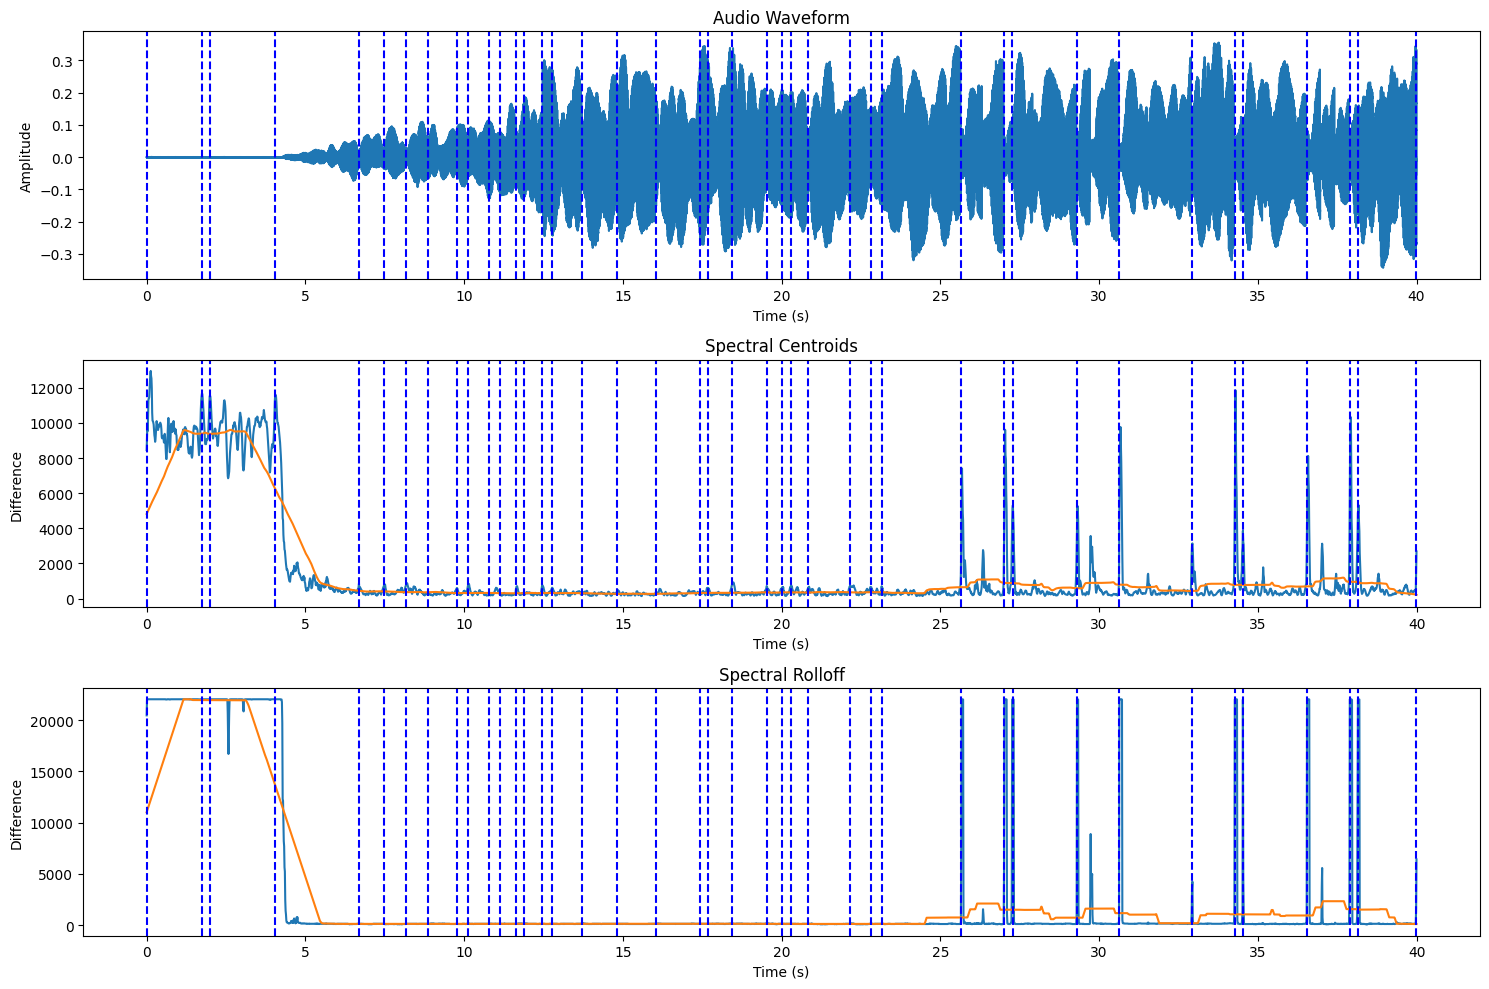

In [9]:
# Plotting
plt.figure(figsize=(15, 10))

# Plot audio data
plt.subplot(3, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(times, focus_data)
plt.title('Audio Waveform')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
# Mark change points on the audio waveform
for timestamp in timestamps:
    plt.axvline(x=timestamp, color='b', linestyle='--')

# Plot frame_diff data
plt.subplot(3, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(frame_times, spectral_centroids)  # Adjust frame_times if necessary
plt.plot(frame_times, ma_centroids)  # Adjust frame_times if necessary
plt.title('Spectral Centroids')
plt.ylabel('Difference')
plt.xlabel('Time (s)')
# Mark change points on the frame_diff plot
for timestamp in timestamps:
    plt.axvline(x=timestamp, color='b', linestyle='--')

# Plot frame_diff data
plt.subplot(3, 1, 3)  # 2 rows, 1 column, second subplot
plt.plot(frame_times, spectral_rolloff)  # Adjust frame_times if necessary
plt.plot(frame_times, ma_rolloff)  # Adjust frame_times if necessary
plt.title('Spectral Rolloff')
plt.ylabel('Difference')
plt.xlabel('Time (s)')
# Mark change points on the frame_diff plot
for timestamp in timestamps:
    plt.axvline(x=timestamp, color='b', linestyle='--')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

In [12]:
timestamps_data = []
for i in range(1, len(timestamps)):
    d = timestamps[i] - timestamps[i - 1]
    timestamps_data.append({
        "index": i,
        "duration": float(d),
        "frames": int(round(d * 8, 0)),
        "caption": "",
        "start_timestamp": float(timestamps[i - 1]),
        "end_timestamp": float(timestamps[i]),
    })

data = {
    "metadata": {
        "audio_file": str(audio_file),
        "duration": int(focus_length),
        "start": int(start),
        "end": int(end)
    },
    "timestamps": timestamps_data,
}

with open("config.yaml", "w") as f:
    dump(data, f)

In [11]:
for file, source in separated.items():
    print(file, source.shape)
    demucs.api.save_audio(source, f"./temp/{file}.mp3", samplerate=separator.samplerate)

drums torch.Size([2, 14717052])
bass torch.Size([2, 14717052])
other torch.Size([2, 14717052])
vocals torch.Size([2, 14717052])
